In [2]:
import os
from tqdm import tqdm
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F  
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import math,random
import sklearn
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, LabelBinarizer, StandardScaler
import utils
import matplotlib.pyplot as plt

C:\Users\loren\anaconda3\envs\dlnn-cuda102\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
print(torch.cuda.is_available())
print(torch.__version__)

True
1.10.1


In [5]:
# recall this is where the data is coming from
DATA_DIR = '/Users/loren/OneDrive/Bureau/NNDL Project/data/fma_small'

# NOTE I DELETED THE TRACK WITH INDEX 297 THAT WAS CAUSING PROBLEMS AND SAVED THE NEW csvfile as trackss.csv
# (the one where I deleted that row)
tracks = utils.load('/Users/loren/OneDrive/Bureau/NNDL Project/data/fma_metadata/tracks.csv')
features = utils.load('/Users/loren/OneDrive/Bureau/NNDL Project/data/fma_metadata/features.csv')
echonest = utils.load('/Users/loren/OneDrive/Bureau/NNDL Project/data/fma_metadata/echonest.csv')

subset = tracks.index[tracks['set', 'subset'] <= 'small']

tracks = tracks.loc[subset]
features_all = features.loc[subset]

tracks.shape, features_all.shape

train_ids = tracks.index[tracks['set', 'split'] == 'training']
val_ids = tracks.index[tracks['set', 'split'] == 'validation']
test_ids = tracks.index[tracks['set', 'split'] == 'test']

#### labels

In [11]:
# labels contains track id and genre associated to it
labels = tracks['track', 'genre_top']
labels = pd.DataFrame(labels)
labels
# in one-hot vector encoding
labels_onehot = LabelBinarizer().fit_transform(tracks['track', 'genre_top'])
labels_onehot = pd.DataFrame(labels_onehot, index=tracks.index)


df = pd.DataFrame(labels)
genres = df.loc[:, ('track','genre_top')]
unique_genres = genres.unique()
print("Number of unique genres in genre_top:",len(unique_genres))
genres = genres.replace(unique_genres, list(range(len(unique_genres))))
genres = pd.DataFrame(genres)
genres

Number of unique genres in genre_top: 8


,track
,genre_top
track_id,
2,0
5,0
10,1
140,2
141,2
...,...
154308,0
154309,0


__spectrogram computation:__

In [12]:
def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
    sig,sr = aud
    top_db = 80

    # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
    spec = torchaudio.transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

    # Convert to decibels
    spec = torchaudio.transforms.AmplitudeToDB(top_db=top_db)(spec)
    return (spec)

__creating a list of all the audio paths (just for doing some tests on data later):__

In [13]:
import os
#import librosa
import numpy as np
import matplotlib.pyplot as plt

AUDIO_DIR = "C:/Users/loren/OneDrive/Bureau/NNDL Project/data/fma_small"
# here I get the path for each audio file by iterating over the folders
folders = os.listdir(AUDIO_DIR)
audio_paths = []
for folder in folders:
    folder_path = os.path.join(AUDIO_DIR,folder)
    for audio_file in os.listdir(folder_path):
        audio_path = os.path.join(folder_path, audio_file)
        audio_paths.append(audio_path)

# checking that indeed in the small dataset we have 8000 songs
print(len(audio_paths))

7999


**checking out what happens to the first n data points (testing the class) + mel_spec plot + similarity:**

 tensor([0., 0., 0., 1., 0., 0., 0., 0.])
tensor(3)
torch.Size([2, 64, 2579])


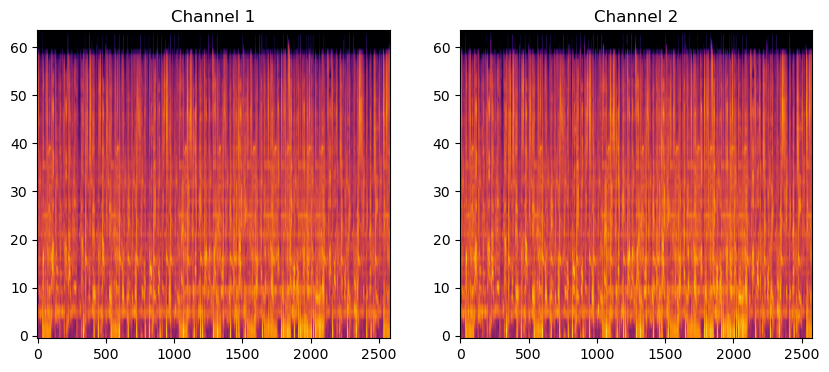

SIMILARITY: 972.31757
Elapsed time:  0.6774096488952637


In [14]:
import time
import soundfile
start = time.time()
n = 1
for filepath in audio_paths[:n]:
    sig,sr = torchaudio.load(filepath)
    label = torch.from_numpy(labels_onehot.loc[2].values).float()
    print("",label)
    print(torch.argmax(label))
    max_len = 44_100//1000 * 30_000
    
    # convert mono to stereo
    if sig.shape[0] != 2:
        sig = torch.cat([sig,sig])

    # standardize sampling rate , since Resample applies to a single channel, we resample one channel at a time :D
    # resample first channel
    if sr != 44100:
        num_channels = sig.shape[0]
        sig1 = torchaudio.transforms.Resample(sr, 44100)(sig[:1,:])
        if (num_channels > 1):
            #resample the second channel and merge both channels
            retwo = torchaudio.transforms.Resample(sr, 44100)(sig[1:,:])
            sig = torch.cat([sig1,retwo])
        else:
            sig = sig1


    num_rows, sig_len = sig.shape
    
    if (sig_len > max_len):
        # Truncate the signal to the given length
        sig = sig[:,:max_len] 
    elif (sig_len < max_len):
        # length of padding to add at the beginning and end of the signal
        pad_begin_len = random.randint(0, max_len - sig_len)
        pad_end_len = max_len - sig_len - pad_begin_len  
        # pad with 0s
        pad_begin = torch.zeros((num_rows, pad_begin_len))
        pad_end = torch.zeros((num_rows, pad_end_len))

        sig = torch.cat((pad_begin, sig, pad_end), 1)
    sig.shape
    aud = sig, 44_100
    spec = spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None)
    print(spec.shape)
    
    # Create a 2x1 grid of subplots
    fig, ax = plt.subplots(nrows=1, ncols=2,figsize = (10,4))

    # Plot the spectrogram of the first channel in the first subplot
    ax[0].imshow(spec[0].numpy(), origin='lower', aspect='auto', cmap='inferno')
    ax[0].set_title('Channel 1')

    # Plot the spectrogram of the second channel in the second subplot
    ax[1].imshow(spec[1].numpy(), origin='lower', aspect='auto', cmap='inferno')
    ax[1].set_title('Channel 2')

    # Show the figure
    plt.show()
    
    #"similarity" between specs
    spectrogram_right = spec[0] # The right channel spectrogram
    spectrogram_left = spec[1] # The left channel spectrogram
    distance = np.linalg.norm(spectrogram_right - spectrogram_left)
    print("SIMILARITY:",distance)
elapsed = time.time() - start
print("Elapsed time: ", elapsed)

----------

**Adding spectrogram data augmentation:** <br>
We will use a technique called SpecAugment that uses these two methods:

- **Frequency mask** : randomly mask out a range of consecutive frequencies by adding horizontal bars on the spectrogram.
- **Time mask** : similar to frequency masks, except that we randomly block out ranges of time from the spectrogram by using vertical bars.

#### Data augmentation techniques on the waveform :
- **time stretching** -> good for music type of problems
- time shifting -> not so good for music apparently
- **pitch shifting** -> good
- noise addition
- impulse response addition
- low/high-pass band filter
- random gain

In [15]:
  # ----------------------------
  # Augment the Spectrogram by masking out some sections of it in both the frequency
  # dimension (ie. horizontal bars) and the time dimension (vertical bars) to prevent
  # overfitting and to help the model generalise better. The masked sections are
  # replaced with the mean value.
# default Ive used so far : 
def spectro_augment(spec, max_mask_pct, n_freq_masks, n_time_masks):
    _, n_mels, n_steps = spec.shape
    mask_value = spec.mean()
    aug_spec = spec

    freq_mask_param = max_mask_pct * n_mels
    for _ in range(n_freq_masks):
        aug_spec = torchaudio.transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

    time_mask_param = max_mask_pct * n_steps
    for _ in range(n_time_masks):
        aug_spec = torchaudio.transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

    return aug_spec

In [16]:
#testing on this:
aug_spec = spectro_augment(spec)
aug_spec.shape

torch.Size([2, 64, 2579])

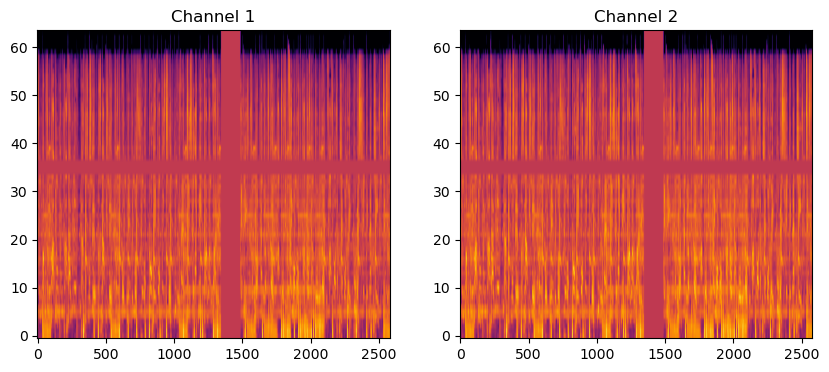

In [17]:
#plotting it
# Create a 2x1 grid of subplots
fig, ax = plt.subplots(nrows=1, ncols=2,figsize = (10,4))

# Plot the spectrogram of the first channel in the first subplot
ax[0].imshow(aug_spec[0].numpy(), origin='lower', aspect='auto', cmap='inferno')
ax[0].set_title('Channel 1')

# Plot the spectrogram of the second channel in the second subplot
ax[1].imshow(aug_spec[1].numpy(), origin='lower', aspect='auto', cmap='inferno')
ax[1].set_title('Channel 2')

# Show the figure
plt.show()

----------

**Data Augmentation on the waveform:**

In [18]:
  # ----------------------------
  # Shifts the signal to the left or right by some percent. Values at the end
  # are 'wrapped around' to the start of the transformed signal.
  # ----------------------------
def time_shift(aud, shift_limit = 0.4):
    sig,sr = aud
    _, sig_len = sig.shape
    shift_amt = int(random.random() * shift_limit * sig_len)
    return (sig.roll(shift_amt), sr)

------------

__Plotting one spectrogram__ <br> <br>
- Y-axis = Mel-frequencies
- X-axis = time in terms of audio samples

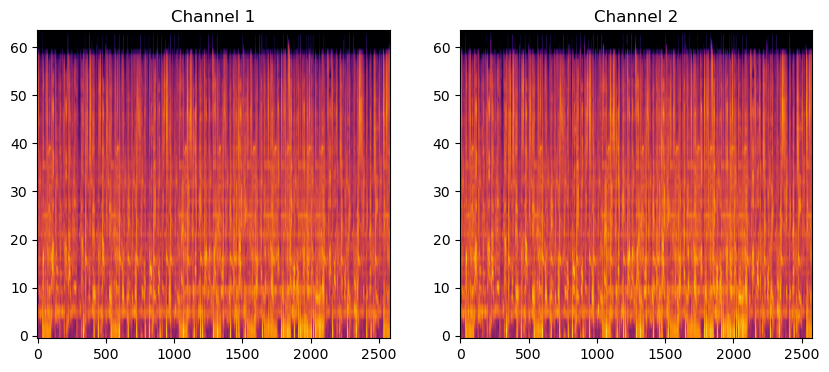

In [19]:
import matplotlib.pyplot as plt

# Create a 2x1 grid of subplots
fig, ax = plt.subplots(nrows=1, ncols=2,figsize = (10,4))

# Plot the spectrogram of the first channel in the first subplot
ax[0].imshow(spec[0].numpy(), origin='lower', aspect='auto', cmap='inferno')
ax[0].set_title('Channel 1')

# Plot the spectrogram of the second channel in the second subplot
ax[1].imshow(spec[1].numpy(), origin='lower', aspect='auto', cmap='inferno')
ax[1].set_title('Channel 2')

# Show the figure
plt.show()

In [20]:
#spec[0] gives the first spec and spec[1] gives the second one
spec.shape

torch.Size([2, 64, 2579])

__similarity between spectrograms:__ <br>
Lower values of the Euclidean distance indicate that the left and right channel are similar, while higher values indicate that they are dissimilar.

In [21]:
# similarity between spectrograms
import numpy as np

# Compute the Euclidean distance between the two spectrograms
spectrogram_right = spec[0] # The right channel spectrogram
spectrogram_left = spec[1] # The left channel spectrogram
distance = np.linalg.norm(spectrogram_right - spectrogram_left)
distance

972.31757

--------------------------------------------------------------------------------------------------------------------------------

__Note : Using _stereo_ signals instead of mono, as for music genre classification this seems to be better, ChatGPT :__ <br>
For music genre classification, using stereo signals may be beneficial as it can provide more information about the audio to the CNN. The spatial characteristics of the sound in a stereo signal can contain information about the instruments used, the arrangement and mixing of the audio, and other features that may be specific to certain genres of music.<br> <br>
The MelSpectrogram function applies a Mel-frequency filter bank to the signal, which maps the linear frequency scale of the signal to a mel-frequency scale, which is more perceptually meaningful for humans, and then applies the Short-time Fourier Transform (STFT) to the signal. The resulting complex numbers are squared to obtain the power spectrum.

--------------


**computing spectrograms and putting them in a folder** <br>

In [137]:
"""import os
import torch
import torchaudio
from torchaudio.transforms import Spectrogram

data_dir = '/Users/loren/OneDrive/Bureau/NNDL Project/data/fma_small'
output_dir = 'C:/Users/loren/OneDrive/Bureau/NNDL Project/augmented_spectrograms'
sampling_rate = 44_100
max_ms = 30_000

# create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
# loop through all MP3 files in the data directory
for root, dirs, files in os.walk(data_dir):
    for filename in files:
        if filename.endswith('.mp3'):
            filepath = os.path.join(root, filename)
            try: 
                sig, sr = torchaudio.load(filepath)
                # convert mono to stereo
                if sig.shape[0] != 2:
                    sig = torch.cat([sig, sig])
    
                # resample to the desired sampling rate
                if sr != sampling_rate:
                    sig = torchaudio.transforms.Resample(sr, sampling_rate)(sig)

                # resize to a fixed length
                num_rows, sig_len = sig.shape
                max_len = 44_100//1000 * max_ms
                if sig_len > max_len:
                    sig = sig[:, :max_len]
                elif sig_len < max_len:
                    pad_begin_len = random.randint(0, max_len - sig_len)
                    pad_end_len = max_len - sig_len - pad_begin_len
                    pad_begin = torch.zeros((num_rows, pad_begin_len))
                    pad_end = torch.zeros((num_rows, pad_end_len))
                    sig = torch.cat((pad_begin, sig, pad_end), 1)

                # compute the spectrogram
                spectro = spectro_gram(aud = (sig,44_100), n_mels=64, n_fft=1024, hop_len=None)
                # *NEW* data augmentation computation
                spectro = spectro_augment(spectro)

                # save the spectrogram to the output directory
                output_file = os.path.join(output_dir, filename[:-4] + '.pt')
                torch.save(spectro, output_file)
            except Exception as e:
                print(e)
                continue"""

Unspecified internal error.
Unspecified internal error.
Unspecified internal error.
Error opening '/Users/loren/OneDrive/Bureau/NNDL Project/data/fma_small\\099\\099134.mp3': File does not exist or is not a regular file (possibly a pipe?).
Error opening '/Users/loren/OneDrive/Bureau/NNDL Project/data/fma_small\\108\\108925.mp3': File does not exist or is not a regular file (possibly a pipe?).


------------------

**NOTE: nn-CrossEntropyLoss() expects as the label one single value (number), so you have to convert the one-hot vector to the class label, which we do using torch.argmax()**

### Note: <br>
- **FMA2D** class processes the data at runtime
- **FMA2D_spec** class already has the pre-computed specs, it just loads them. *NEW* : added the option to augment them with a given probability
- **FMA2D_spec2** class loads also the augmented spectrogra

In [457]:
# creating the class for 2DCNN:
class FMA2D(Dataset):
    def __init__(self, data_dir, track_ids, sampling_rate=44_100, max_ms = 30_000):
        self.data_dir = data_dir
        self.filenames = os.listdir(data_dir)
        self.track_ids = track_ids
        self.sampling_rate = sampling_rate
        self.max_ms = max_ms
        
    def __getitem__(self,index):
        tid = self.track_ids[index]
        #load MP3 file
        filepath = utils.get_audio_path(self.data_dir, tid)
        try:
            sig, sr = torchaudio.load(filepath)
        except Exception as e:
            return self.__getitem__(index + 1)
        #label
        label = torch.argmax(torch.from_numpy(labels_onehot.loc[tid].values).float())
        #---------
        #if self.one_hot == True:
        #    label = torch.from_numpy(labels_onehot.loc[tid].values).float()
        #else:
        #label = genres.loc[tid].values
        #-------
        # convert mono to stereo
        if sig.shape[0] != 2:
            sig = torch.cat([sig,sig])
            
        # standardize sampling rate , since Resample applies to a single channel, we resample one channel at a time :D
        # resample first channel
        if sr != self.sampling_rate:
            num_channels = sig.shape[0]
            sig1 = torchaudio.transforms.Resample(sr, self.sampling_rate)(sig[:1,:])
            if (num_channels > 1):
                # resample the second channel and merge both channels
                retwo = torchaudio.transforms.Resample(sr, self.sampling_rate)(sig[1:,:])
                sig = torch.cat([sig1,retwo])
            elif num_channels == 1:
                sig = sig1
                
        # we resize audio samples to have the same length by either extending its duration by padding it with silence, or by
        # truncating it
        num_rows, sig_len = sig.shape
        max_len = 44_100//1000 * self.max_ms
        
        if (sig_len > max_len):
          # Truncate the signal to the given length
          sig = sig[:,:max_len] 
            
        elif (sig_len < max_len):
            # length of paddinf to add at the beginning and end of the signal
            pad_begin_len = random.randint(0, max_len - sig_len)
            pad_end_len = max_len - sig_len - pad_begin_len  
            # pad with 0s
            pad_begin = torch.zeros((num_rows, pad_begin_len))
            pad_end = torch.zeros((num_rows, pad_end_len))
            
            sig = torch.cat((pad_begin, sig, pad_end), 1)
        
        # now we generate the spectrogram
        aud = sig, self.sampling_rate
        spec = spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None)
        return spec, label
    
    def __len__(self):
        return len(self.track_ids)

In [458]:
class FMA2D_spec(Dataset):   
    def __init__(self, data_dir, track_ids, sampling_rate=44_100, max_ms = 30_000, transforms = True, augment_prob = 0.5):
        self.data_dir = data_dir
        self.filenames = os.listdir(data_dir)
        self.track_ids = track_ids
        self.sampling_rate = sampling_rate
        self.max_ms = max_ms
        self.transforms = transforms
        self.augment_prob = augment_prob
        
    def __getitem__(self, index):
        tid = self.track_ids[index]
        # load the spectrogram data
        spec_path = os.path.join('./spectrograms/'+"{:06d}".format(tid)+'.pt')
        try:
            spec = torch.load(spec_path)
        except Exception as e:
            return self.__getitem__(index + 1)
        if self.transforms is True and torch.rand(1) < self.augment_prob:
            spec = spectro_augment(spec)
        #get label
        label = torch.argmax(torch.from_numpy(labels_onehot.loc[tid].values).float())
        return spec, label
        
    def __len__(self):
        return len(self.track_ids)

In [459]:
class FMA2D_spec2(Dataset):   
    def __init__(self, data_dir, track_ids):
        self.data_dir = data_dir
        self.filenames = os.listdir(data_dir)
        self.track_ids = track_ids
        self.paths = []
        folders = ['spectrograms', 'augmented_spectrograms']
        for folder in folders:
            for tid in track_ids:
                self.paths.append([os.path.join(f'./{folder}/'+"{:06d}".format(tid)+'.pt'), tid])
        
    def __getitem__(self, index):
        # load the spectrogram data
        spec_path = self.paths[index][0]
        label = torch.argmax(torch.from_numpy(labels_onehot.loc[self.paths[index][1]].values).float())
        try:
            spec = torch.load(spec_path)
        except Exception as e:
            return self.__getitem__(index + 1)
        #get label
        
        return spec, label
        
    def __len__(self):
        return len(self.track_ids)*2

--------------------------------------------------------------------------------------------------------------------------------

Notes on the model : <br>
- 4 conv blocks, each followed by 
- Kaiming initialization, also known as He initialization, is a method for initializing the weights of a neural network. It was proposed by He et al. in the paper "Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification" (2015). The idea behind Kaiming initialization is to initialize the weights in such a way that the variance of the output of each neuron is the same as the variance of its input, so that the forward and backward signals can flow easily through the network. In the case of Kaiming_normal, the weights are initialized according to a normal distribution with zero mean and a standard deviation of $sqrt(2/fan_in)$ where fan_in is the number of input units in the weight tensor.
- .bias.data.zero_() sets the bias to 0, so in the o.g. architecture they set it to 0 after each convolution block, i.e. it is not a trainable parameter anymore since it is always 0 (do experiments on changing this). This is a form of regularization

In [505]:
import torch.nn.functional as F
from torch.nn import init

class AudioClassifier (nn.Module):
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Second Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Second Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=8)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)
 
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.lin(x)

        # Final output
        return x

# to start with a clean clean slate at each iteration, if you don't do zero_grad(),  
# the running sum of gradients in batch normalization layers isn't reset
myModel = None
myModel = AudioClassifier()
myModel.zero_grad()


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(device)
# Check that it is on Cuda
next(myModel.parameters()).device

device(type='cuda', index=0)

In [506]:
# augmentation details
max_mask_pct=0.7
n_freq_masks=3
n_time_masks=3

dataset_train = FMA2D_spec(DATA_DIR, train_ids,transforms = True, augment_prob = 0.8)
dataset_valid = FMA2D_spec(DATA_DIR, val_ids, transforms = False)
dataset_test = FMA2D_spec(DATA_DIR, test_ids)


# Create training and validation data loaders
train_dl_sp = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=True)
val_dl_sp = torch.utils.data.DataLoader(dataset_valid, batch_size=32, shuffle=True)

#### to take a smaller training data

In [507]:
subsample_size = 4_480
subsample_dataset_train = torch.utils.data.Subset(dataset_train, indices=range(subsample_size))
train_dl_sp = torch.utils.data.DataLoader(subsample_dataset_train, batch_size=32, shuffle=True)

val_subsample_size = 576
subsample_dataset_valid = torch.utils.data.Subset(dataset_valid, indices=range(val_subsample_size))
val_dl_sp = torch.utils.data.DataLoader(subsample_dataset_valid, batch_size=32, shuffle=True)

In [508]:
for data, label in train_dl_sp:
    print(data.shape,"\n",label.shape)
    print(label)
    break
print(len(train_dl_sp))

for data, label in val_dl_sp:
    print(data.shape,"\n",label.shape)
    print(label)
    break
print(len(val_dl_sp))

torch.Size([32, 2, 64, 2579]) 
 torch.Size([32])
tensor([7, 1, 1, 3, 6, 6, 1, 2, 6, 1, 4, 5, 3, 0, 2, 2, 2, 0, 7, 4, 5, 0, 6, 1,
        2, 5, 5, 5, 1, 5, 6, 6])
140
torch.Size([32, 2, 64, 2579]) 
 torch.Size([32])
tensor([1, 3, 0, 1, 6, 4, 3, 7, 0, 1, 4, 0, 2, 3, 6, 7, 3, 3, 3, 2, 7, 3, 7, 7,
        5, 1, 5, 1, 7, 3, 4, 1])
18


---------

In [509]:
def training_valid(model, train_dl_sp, val_dl_sp, num_epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.001,weight_decay = 0.001)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,steps_per_epoch=int(len(train_dl_sp)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')
    
    train_accs = []
    val_accs = []
    train_losses = []
    val_losses = []
    number_of_samples = 0
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_prediction = 0
        total_prediction = 0
        for i, (data,label) in enumerate(train_dl_sp):
            number_of_samples += 1
            inputs, labels = data.to(device), label.to(device)
            #inputs_m, inputs_s = inputs.mean(), inputs.std()
            #inputs = (inputs - inputs_m) / inputs_s

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            # ADDED .zero_grad() now
            model.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item()
            #NOTE : the "prediction" here below is the index of the max value of the output tensor
            # _ is the output tensor (1D 8component tensor) and pred is the index
            _, prediction = torch.max(outputs,1)
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]
            if total_prediction == 0:
                acc = 0
            else:
                acc = correct_prediction/total_prediction

        num_batches = len(train_dl_sp)
        train_loss = running_loss / num_batches
        train_accs.append(acc)
        train_losses.append(train_loss)
        print(f'Epoch: {epoch}, Train Loss: {train_loss:.2f}, Training Accuracy: {acc:.2f}')
        model.eval()
        #Validation Loop
        with torch.no_grad():
            val_loss = 0.0
            val_correct_prediction = 0
            val_total_prediction = 0
            for data, label in val_dl_sp:
                inputs, labels = data.to(device), label.to(device)
                #inputs_m, inputs_s = inputs.mean(), inputs.std()
                #inputs = (inputs - inputs_m) / inputs_s
                outputs = model(inputs)
                val_loss += criterion(outputs, labels)
                _, val_prediction = torch.max(outputs,1)
                val_correct_prediction += (val_prediction == labels).sum().item()
                val_total_prediction += val_prediction.shape[0]
                if val_total_prediction == 0:
                    val_acc = 0
                else:
                    val_acc = val_correct_prediction/val_total_prediction
            val_loss /= len(val_dl_sp)
            val_accs.append(val_acc)
            val_losses.append(val_loss)
            print(f' Validation Loss: {val_loss:.2f}, Validation Accuracy: {val_acc:.2f}')
            print("--------------------------------------------")
        model.train()
        
    # max validation acc
    print(max(val_accs))
    #plotting results
    fig, axs = plt.subplots(1,2,figsize = (15,5))
    
    #accuracies
    axs[0].plot(train_accs, label='Training Accuracy')
    axs[0].plot(val_accs, label='Validation Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()
    
    #losses
    val_losses = torch.tensor(val_losses)
    axs[1].plot(train_losses, label='Training Loss')
    axs[1].plot(val_losses.detach().numpy(), label='Validation Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend()
    plt.show()
    

training_valid(myModel, train_dl_sp, val_dl_sp, num_epochs = 100)

Epoch: 0, Train Loss: 2.04, Training Accuracy: 0.20
 Validation Loss: 1.94, Validation Accuracy: 0.26
--------------------------------------------
Epoch: 1, Train Loss: 1.93, Training Accuracy: 0.28
 Validation Loss: 1.86, Validation Accuracy: 0.30
--------------------------------------------
Epoch: 2, Train Loss: 1.86, Training Accuracy: 0.32
 Validation Loss: 1.78, Validation Accuracy: 0.35
--------------------------------------------
Epoch: 3, Train Loss: 1.79, Training Accuracy: 0.35
 Validation Loss: 1.69, Validation Accuracy: 0.41
--------------------------------------------
Epoch: 4, Train Loss: 1.72, Training Accuracy: 0.38
 Validation Loss: 1.64, Validation Accuracy: 0.38
--------------------------------------------
Epoch: 5, Train Loss: 1.67, Training Accuracy: 0.39
 Validation Loss: 1.59, Validation Accuracy: 0.43
--------------------------------------------
Epoch: 6, Train Loss: 1.64, Training Accuracy: 0.40
 Validation Loss: 1.55, Validation Accuracy: 0.44
----------------

Epoch: 56, Train Loss: 0.91, Training Accuracy: 0.69
 Validation Loss: 1.30, Validation Accuracy: 0.56
--------------------------------------------
Epoch: 57, Train Loss: 0.89, Training Accuracy: 0.70
 Validation Loss: 1.35, Validation Accuracy: 0.55
--------------------------------------------
Epoch: 58, Train Loss: 0.90, Training Accuracy: 0.70
 Validation Loss: 1.35, Validation Accuracy: 0.53
--------------------------------------------
Epoch: 59, Train Loss: 0.89, Training Accuracy: 0.70
 Validation Loss: 1.36, Validation Accuracy: 0.53
--------------------------------------------
Epoch: 60, Train Loss: 0.88, Training Accuracy: 0.70
 Validation Loss: 1.31, Validation Accuracy: 0.55
--------------------------------------------
Epoch: 61, Train Loss: 0.87, Training Accuracy: 0.71
 Validation Loss: 1.32, Validation Accuracy: 0.56
--------------------------------------------
Epoch: 62, Train Loss: 0.86, Training Accuracy: 0.71
 Validation Loss: 1.36, Validation Accuracy: 0.56
---------

KeyboardInterrupt: 

In [ ]:
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__CUDA Device Name:',torch.cuda.get_device_name(0))
print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

In [ ]:
import torchinfo
torchinfo.summary(myModel, input_size =(32, 2, 64, 2579))

In [308]:
model_name = '2DCNNLorenzo_2022-01-23_batchsize_64_epochs_100_opt_Adam_LR_0.001_WithDropout_WithAugmentedSpecs'
torch.save(myModel.state_dict(), model_name + ".pt")

### Some Results <br>
### with max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1

**Model : AudioClassifier without data augmentation(6400 samples):** <br>
**batch size 64**: <br> 
**bias set to 0 after each conv block** <br>
**no dropout** <br>
Epoch: 39, Train Loss: 0.93, Training Accuracy: 0.68
 Validation Loss: 1.38, **Validation Accuracy: 0.55** <br>Remark: Model still not overfitting <br>
 
**Model : AudioClassifier with data augmentation on train set(6400x2 samples):** <br>
**batch size 128**: <br> 
**bias set to 0 after each conv block** <br>
**no dropout** <br>
Epoch: 19, Train Loss: 1.09, Training Accuracy: 0.62
 Validation Loss: 1.33, **Validation Accuracy: 0.56**
 
**Model : AudioClassifier with data augmentation on train set(6400x2 samples):** <br>
**batch size 256**: <br> 
**bias set to 0 after each conv block** <br>
**no dropout** <br>
Epoch: 30, Train Loss: 1.04, Training Accuracy: 0.64
 Validation Loss: 1.33, **Validation Accuracy: 0.55**

**Model : AudioClassifier with data augmentation on train set(6400x2 samples):** <br>
**batch size 128**: <br> 
**bias set to 0 after each conv block** <br>
**no dropout** <br>
**added .zero_grad() to empty the grads after each batch backprop has been computed (didnt make a diff?)** <br>
 Epoch: 32, Train Loss: 0.91, Training Accuracy: 0.69
 Validation Loss: 1.35, **Validation Accuracy: 0.56**
 
**Model : AudioClassifier with data augmentation on train set(6400 samples):** <br>
**batch size 32**: <br> 
**bias set to 0 after each conv block** <br>
**no dropout**, **augm prob = 0.5** <br>
 Epoch: 116, Train Loss: 1.16, Training Accuracy: 0.60
 Validation Loss: 1.27, **Validation Accuracy: 0.57**
 
**Model : AudioClassifier with data augmentation on train set(3520 samples) valid data set size 416:** <br>
**batch size 32**: <br> 
**bias set to 0 after each conv block** <br>
**no dropout**, **augm prob = 0.7** <br>
**removed last conv block**
 Epoch: 146, Train Loss: 1.17, Training Accuracy: 0.59 <br>
 Validation Loss: 1.26, **Validation Accuracy: 0.58**

**Model : AudioClassifier with data augmentation on train set(3520 samples) valid data set size 416:** <br>
**batch size 32**: <br> 
**bias set to 0 after each conv block** <br>
**no dropout**, **augm prob = 0.6** <br>
**added last conv block back again**
Epoch: 101, Train Loss: 0.61, Training Accuracy: 0.81 <br>
Validation Loss: 1.29, **Validation Accuracy: 0.58**

**Model : AudioClassifier with data augmentation on train set(3520 samples) valid data set size 416:** <br>
**batch size 32**: <br> 
**bias set to 0 after each conv block** <br>
**no dropout**, **augm prob = 1** <br>
**added last conv block back again** <br>
Epoch: 54, Train Loss: 0.93, Training Accuracy: 0.68
 Validation Loss: 1.24, **Validation Accuracy: 0.59**

### with max_mask_pct=0.2, n_freq_masks=1, n_time_masks=1
**Model : AudioClassifier with data augmentation on train set(3520 samples) valid data set size 416:** <br>
**batch size 32**: <br> 
**bias set to 0 after each conv block** <br>
**no dropout**, **augm prob = 0.9** <br>
**added last conv block back again** <br>
Epoch: 42, Train Loss: 1.10, Training Accuracy: 0.61
 Validation Loss: 1.22, **Validation Accuracy: 0.60**

### with max_mask_pct=0.7, n_freq_masks=3, n_time_masks=3
**Model : AudioClassifier with data augmentation on train set(4480 samples) valid data set size 576:** <br>
**batch size 32**: <br> 
**bias set to 0 after each conv block** <br>
**no dropout**, **augm prob = 0.8** <br>
**added last conv block back again** <br>
waiting for results boiiii

###  Gridsearch with skorch (wrapper for PyTorch)

In [347]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from skorch import NeuralNetClassifier
from sklearn.model_selection import train_test_split
from skorch.helper import predefined_split
from skorch.dataset import Dataset
from skorch.callbacks import PrintLog, EarlyStopping, Checkpoint

**We don't need DataLoader anymore:**

In [348]:
dataset_train = FMA2D_spec2(DATA_DIR, train_ids)
dataset_valid = FMA2D_spec(DATA_DIR, val_ids)
dataset_test = FMA2D_spec(DATA_DIR, test_ids)

In [349]:
isinstance(dataset_train[0],tuple)

True

In [350]:
params = {
    "lr" = [0.001,0.002],
    "batch_size" = [64,128,256],
}

SyntaxError: invalid syntax (3826828366.py, line 2)

In [318]:
from skorch import NeuralNetClassifier

#he
net = NeuralNetClassifier(
    module=AudioClassifier,
    device="cuda",
    criterion=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam,
    max_epochs=50,
    train_split=predefined_split(dataset_valid),
    batch_size = 128,
    classes = 8,
    lr = 0.001,
    warm_start = True,
    callbacks=[]
)
net.fit(dataset_train,y=None)

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.8568       0.2963        1.7876  48.8595
      2        1.7114       0.3513        1.7259  48.4627


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=AudioClassifier(
    (conv1): Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (relu1): ReLU()
    (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu2): ReLU()
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu3): ReLU()
    (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu4): ReLU()
    (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (ap): AdaptiveAvgPool2d(output_size=1)
    (lin): Linear(in_features=64, out_features=8, bias=True)
    (conv): Sequential(
      (0): Conv2d(2, 8, ker

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    'module__dropout1': [0.3, 0.4],
}

clf = GridSearchCV(net, params, refit=False, cv=5, scoring='accuracy')
clf.fit((train_dl_sp,None), validation_data=(val_dl_sp,None))


----

### Next CNN architecture from microsoft:

In [ ]:
class CNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(51136, 50)
        self.fc2 = nn.Linear(50, 2)


    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #x = x.view(x.size(0), -1)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        return F.log_softmax(x,dim=1)  

model = CNNet().to(device)

## CRNN from https://arxiv.org/pdf/1712.08370.pdf

In [46]:
import torch
import torch.nn as nn

class CRNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1d = nn.Conv2d(2, 64, kernel_size=(3,3), padding=(1,1))
        self.batch_normalization = nn.BatchNorm2d(64)
        self.max_pooling1d = nn.MaxPool1d(2)
        self.dropout = nn.Dropout()
        self.conv1d_1 = nn.Conv2d(64, 64, kernel_size=(3,3), padding=(1,1))
        self.batch_normalization_1 = nn.BatchNorm2d(64)
        self.max_pooling1d_1 = nn.MaxPool1d(2)
        self.dropout_1 = nn.Dropout()
        self.conv1d_2 = nn.Conv2d(64, 64, kernel_size=(3,3), padding=(1,1))
        self.batch_normalization_2 = nn.BatchNorm2d(64)
        self.max_pooling1d_2 = nn.MaxPool1d(2)
        self.dropout_2 = nn.Dropout()
        self.lstm = nn.LSTM(64, 64)
        self.dropout_3 = nn.Dropout()
        self.dense = nn.Linear(64, 64)
        self.dropout_4 = nn.Dropout()
        self.dense_1 = nn.Linear(64, 8)

    def forward(self, x):
        print(x.shape)
        x = self.conv1d(x)
        x = self.batch_normalization(x)
        x = self.max_pooling1d(x)
        x = self.dropout(x)
        x = self.conv1d_1(x)
        x = self.batch_normalization_1(x)
        x = self.max_pooling1d_1(x)
        x = self.dropout_1(x)
        x = self.conv1d_2(x)
        x = self.batch_normalization_2(x)
        x = self.max_pooling1d_2(x)
        x = self.dropout_2(x)
        x = self.lstm(x)
        x = self.dropout_3(x)
        x = self.dense(x)
        x = self.dropout_4(x)
        x = self.dense_1(x)
        return x

myModel = None
myModel = CRNN()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(device)
# Check that it is on Cuda
next(myModel.parameters()).device

device(type='cuda', index=0)

In [47]:
DATA_DIR = '/Users/loren/OneDrive/Bureau/NNDL Project/data/fma_small'
DATA_DIR_sp = "/Users/loren/OneDrive/Bureau/NNDL Project"

dataset_train_sp = FMA2D_spec(DATA_DIR_sp, train_ids)
dataset_valid_sp = FMA2D_spec(DATA_DIR_sp, val_ids)
dataset_test_sp = FMA2D_spec(DATA_DIR_sp, test_ids)

#dataset_train_sp = FMA2D_spec2(DATA_DIR_sp, train_ids)
#dataset_valid_sp = FMA2D_spec2(DATA_DIR_sp, val_ids)
#dataset_test_sp = FMA2D_spec2(DATA_DIR_sp, test_ids)

# Create training and validation data loaders
train_dl_sp = torch.utils.data.DataLoader(dataset_train_sp, batch_size= 64, shuffle=True)
val_dl_sp = torch.utils.data.DataLoader(dataset_valid_sp, batch_size= 64, shuffle=False)

# what a data batch along with its labels looks like
for data, label in train_dl_sp:
    print(data.shape,"\n",label.shape)
    print(label,"\n")
    break

for data, label in val_dl_sp:
    print(data.shape,"\n",label.shape)
    print(label)
    break

torch.Size([64, 2, 64, 2579]) 
 torch.Size([64])
tensor([2, 4, 6, 1, 7, 1, 2, 7, 5, 2, 5, 1, 5, 1, 1, 3, 4, 1, 3, 3, 4, 1, 1, 2,
        7, 4, 4, 3, 3, 4, 3, 6, 6, 7, 1, 0, 4, 4, 6, 6, 3, 5, 6, 3, 3, 3, 7, 1,
        7, 5, 4, 6, 1, 6, 2, 6, 3, 2, 5, 7, 0, 6, 2, 3]) 

torch.Size([64, 2, 64, 2579]) 
 torch.Size([64])
tensor([1, 7, 2, 7, 7, 7, 2, 1, 2, 2, 2, 2, 7, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        2, 2, 2, 2, 2, 2, 2, 0, 7, 7, 7, 7, 7, 7, 3, 6, 3, 6, 3, 0, 7, 3, 5, 5,
        5, 5, 5, 5, 3, 3, 3, 0, 0, 0, 0, 0, 0, 6, 6, 6])


In [48]:
def training_valid(model, train_dl_sp, val_dl_sp, num_epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,steps_per_epoch=int(len(train_dl_sp)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')
    
    train_accs = []
    val_accs = []
    train_losses = []
    val_losses = []
    number_of_samples = 0
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_prediction = 0
        total_prediction = 0
        for i, data in enumerate(train_dl_sp):
            number_of_samples += 1
            inputs, labels = data[0].to(device), data[1].to(device)
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item()
            _, prediction = torch.max(outputs,1)
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]
            if total_prediction == 0:
                acc = 0
            else:
                acc = correct_prediction/total_prediction

        num_batches = len(train_dl_sp)
        avg_loss = running_loss / num_batches
        train_accs.append(acc)
        train_losses.append(avg_loss)
        print(f'Epoch: {epoch}, Train Loss: {avg_loss:.2f}, Training Accuracy: {acc:.2f}')

        #Validation Loop
        with torch.no_grad():
            val_loss = 0.0
            val_correct_prediction = 0
            val_total_prediction = 0
            running_loss_val = 0
            for data in val_dl_sp:
                inputs, labels = data[0].to(device), data[1].to(device)
                inputs_m, inputs_s = inputs.mean(), inputs.std()
                inputs = (inputs - inputs_m) / inputs_s
                outputs = model(inputs)
                val_loss = criterion(outputs, labels)
                
                running_loss_val += val_loss.item()
                _, val_prediction = torch.max(outputs,1)
                val_correct_prediction += (val_prediction == labels).sum().item()
                val_total_prediction += val_prediction.shape[0]
                if val_total_prediction == 0:
                    val_acc = 0
                else:
                    val_acc = val_correct_prediction/val_total_prediction
            running_loss_val /= len(val_dl_sp)
            val_accs.append(val_acc)
            val_losses.append(running_loss_val)
            print(f' Validation Loss: {val_loss:.2f}, Validation Accuracy: {val_acc:.2f}')
            print("--------------------------------------------")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(train_accs, label='Training Accuracy')
    ax1.plot(val_accs, label='Validation Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax2.plot(train_losses, label='Training Loss')
    ax2.plot(val_losses, label='Validation Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    plt.show()


training_valid(myModel, train_dl_sp, val_dl_sp, num_epochs = 50)

torch.Size([64, 2, 64, 2579])


RuntimeError: CUDA out of memory. Tried to allocate 2.52 GiB (GPU 0; 6.00 GiB total capacity; 2.68 GiB already allocated; 1.45 GiB free; 2.68 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF